### imports

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns

### read csv files


In [31]:
users = pd.read_csv('../../data/processed/cleaned_users.csv')
distribution_centers = pd.read_csv('../../data/processed/cleaned_distribution_centers.csv')
order_items = pd.read_csv('../../data/processed/cleaned_order_items.csv')
inventory_items = pd.read_csv('../../data/processed/cleaned_inventory_items.csv')
events = pd.read_csv('../../data/processed/cleaned_events.csv')
orders = pd.read_csv('../../data/processed/cleaned_orders.csv')
products = pd.read_csv('../../data/processed/cleaned_products.csv')

### 1. Geospatial Analysis (Distribution Centers and Users)


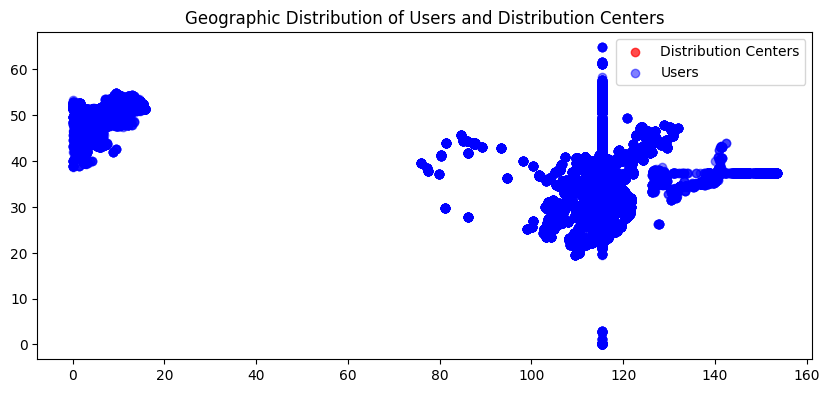

In [32]:

users_gdf = gpd.GeoDataFrame(users, geometry=gpd.GeoSeries.from_xy(users.longitude, users.latitude))
dc_gdf = gpd.GeoDataFrame(distribution_centers, geometry=gpd.GeoSeries.from_xy(distribution_centers.longitude, distribution_centers.latitude))

fig, ax = plt.subplots(figsize=(10, 10))
dc_gdf.plot(ax=ax, color='red', label='Distribution Centers', alpha=0.7)
users_gdf.plot(ax=ax, color='blue', label='Users', alpha=0.5)
plt.title("Geographic Distribution of Users and Distribution Centers")
plt.legend()
plt.show()


### 2. User Behavior Analysis


Session Patterns: Plot the number of events by session ID or by user to understand session activity.
python

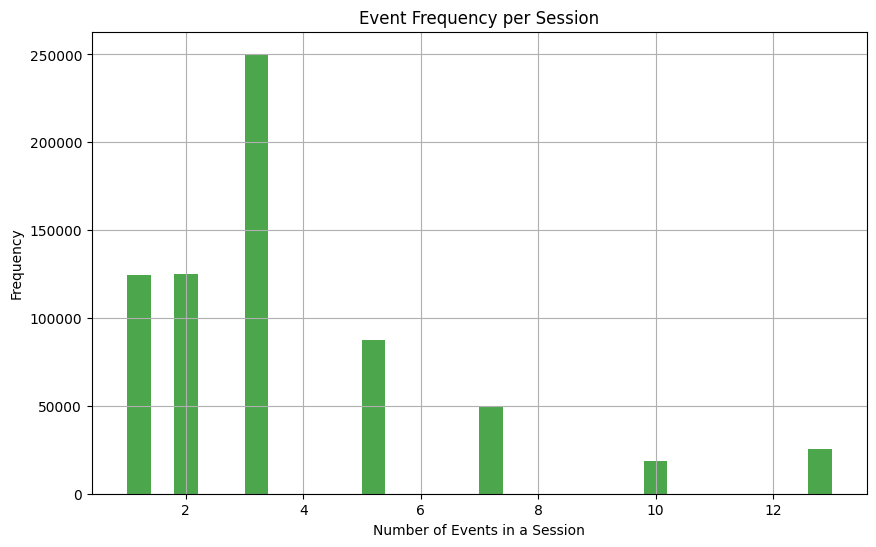

In [33]:

session_counts = events.groupby('session_id').size()

plt.figure(figsize=(10, 6))
session_counts.hist(bins=30, color='green', alpha=0.7)
plt.title("Event Frequency per Session")
plt.xlabel("Number of Events in a Session")
plt.ylabel("Frequency")
plt.show()


Traffic Sources: Visualize the distribution of different traffic sources.
python

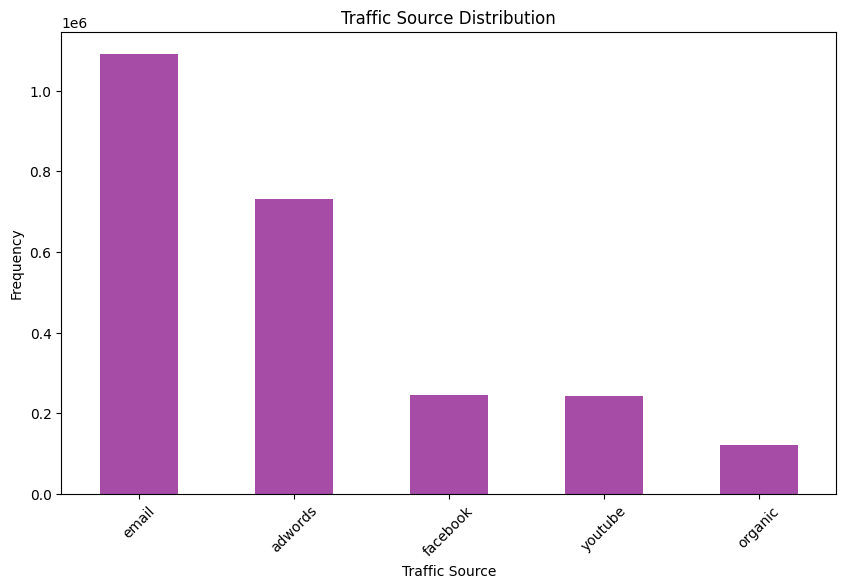

In [34]:
traffic_source_counts = events['traffic_source'].value_counts()

plt.figure(figsize=(10, 6))
traffic_source_counts.plot(kind='bar', color='purple', alpha=0.7)
plt.title("Traffic Source Distribution")
plt.xlabel("Traffic Source")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


### 3. Sales and Revenue Analysis


In [35]:
display(order_items.columns)
display(inventory_items.columns)

Index(['id', 'order_id', 'user_id', 'product_id', 'inventory_item_id',
       'status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at',
       'sale_price'],
      dtype='object')

Index(['id', 'product_id', 'created_at', 'sold_at', 'cost', 'product_category',
       'product_name', 'product_brand', 'product_retail_price',
       'product_department', 'product_sku', 'product_distribution_center_id'],
      dtype='object')

In [36]:
sales_data = pd.merge(order_items, inventory_items, left_on='inventory_item_id', right_on='id')
sales_data.columns

Index(['id_x', 'order_id', 'user_id', 'product_id_x', 'inventory_item_id',
       'status', 'created_at_x', 'shipped_at', 'delivered_at', 'returned_at',
       'sale_price', 'id_y', 'product_id_y', 'created_at_y', 'sold_at', 'cost',
       'product_category', 'product_name', 'product_brand',
       'product_retail_price', 'product_department', 'product_sku',
       'product_distribution_center_id'],
      dtype='object')

In [37]:
sales_data['product_id'] = sales_data['product_id_y']
sales_data.drop(columns=['product_id_x', 'product_id_y', 'id_y'], inplace=True)

sales_data['quantity_sold'] = sales_data.groupby('inventory_item_id')['order_id'].transform('count')

sales_data['total_sales'] = sales_data['quantity_sold'] * sales_data['cost']

product_sales = sales_data.groupby('product_id')['total_sales'].sum().sort_values(ascending=False)

print(product_sales.head())

product_id
24428    6298.425023
8721     5353.529986
17094    4721.787002
23803    4537.920015
24899    4457.208017
Name: total_sales, dtype: float64


 Top 10 Products by Total Sales (Bar Plot)

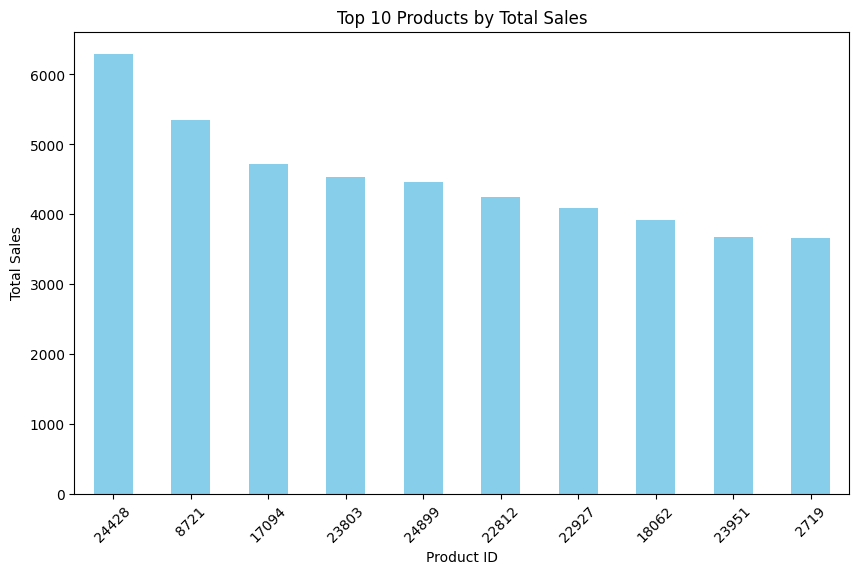

In [38]:

top_10_products = product_sales.head(10)

plt.figure(figsize=(10, 6))
top_10_products.plot(kind='bar', color='skyblue')
plt.title('Top 10 Products by Total Sales')
plt.xlabel('Product ID')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


Total Sales Distribution (Histogram)

### 4. User Demographics Analysis


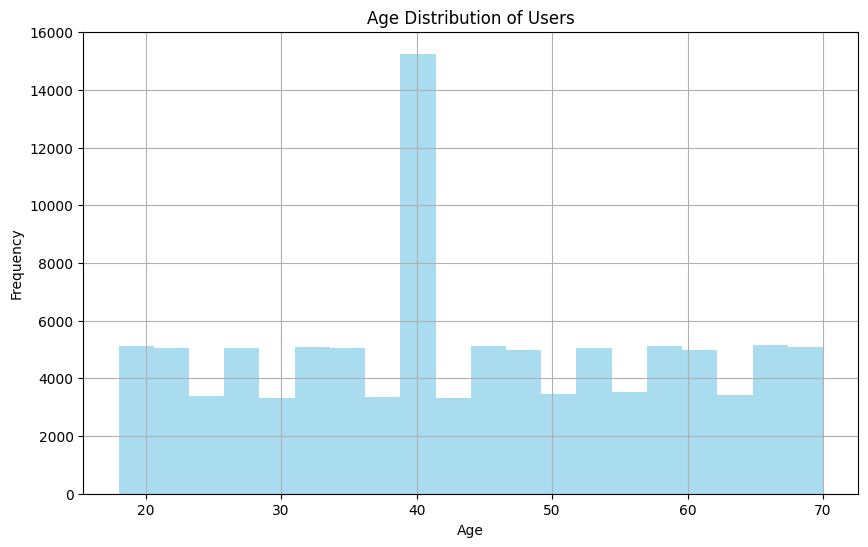

In [39]:

plt.figure(figsize=(10, 6))
users['age'].hist(bins=20, color='skyblue', alpha=0.7)
plt.title("Age Distribution of Users")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


Gender Distribution of Users: Visualize the gender distribution of users.
python

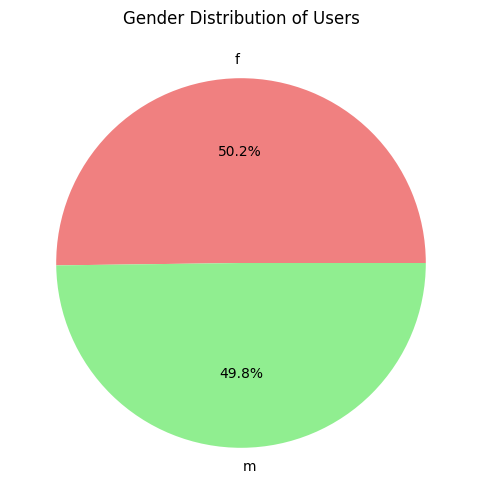

In [40]:
gender_counts = users['gender'].value_counts()

plt.figure(figsize=(6, 6))
gender_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title("Gender Distribution of Users")
plt.ylabel("")
plt.show()


### 5. Order Fulfillment Analysis


Order Fulfillment Time: Visualize the time it takes for orders to be fulfilled (from creation to shipping or delivery).
python

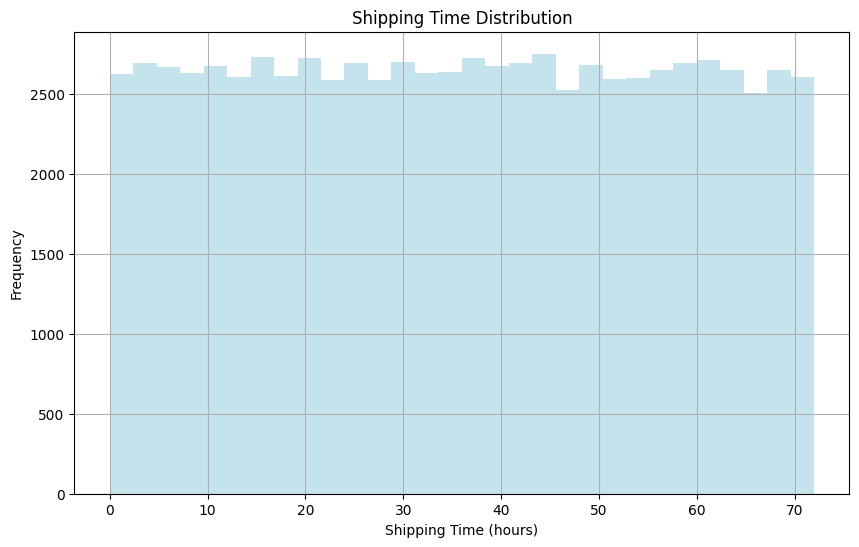

In [41]:

orders['created_at'] = pd.to_datetime(orders['created_at'])
orders['shipped_at'] = pd.to_datetime(orders['shipped_at'])
orders['delivered_at'] = pd.to_datetime(orders['delivered_at'])

orders['shipping_time'] = (orders['shipped_at'] - orders['created_at']).dt.total_seconds() / 3600  # In hours
orders['delivery_time'] = (orders['delivered_at'] - orders['created_at']).dt.total_seconds() / 3600  # In hours

plt.figure(figsize=(10, 6))
orders['shipping_time'].hist(bins=30, color='lightblue', alpha=0.7)
plt.title("Shipping Time Distribution")
plt.xlabel("Shipping Time (hours)")
plt.ylabel("Frequency")
plt.show()


### 6. Correlation of Numerical Features


Correlation Matrix: Plot a heatmap of correlations between numerical features to understand relationships between different attributes (like cost, retail price, number of items in orders, etc.).
python
Copier le code


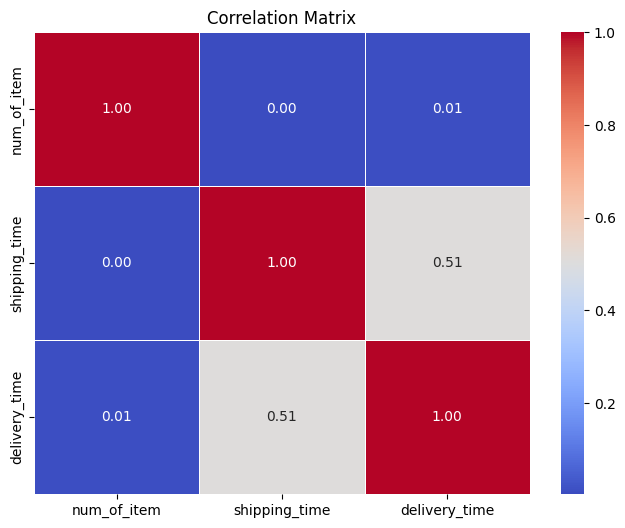

In [42]:

correlation_matrix = orders[['num_of_item', 'shipping_time', 'delivery_time']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


### 7. Product Performance Analysis


Cost vs. Retail Price: Visualize the relationship between product cost and retail price.
python
Copier le code


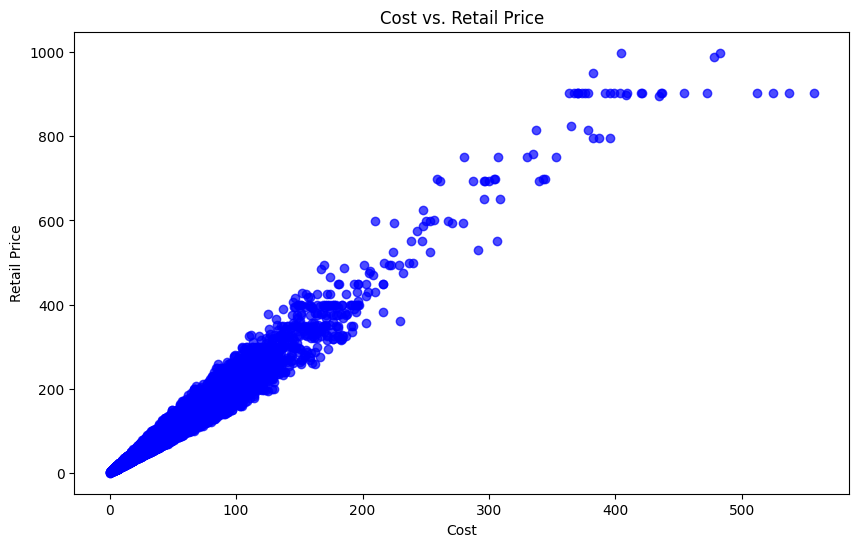

In [43]:

plt.figure(figsize=(10, 6))
plt.scatter(products['cost'], products['retail_price'], alpha=0.7, color='blue')
plt.title("Cost vs. Retail Price")
plt.xlabel("Cost")
plt.ylabel("Retail Price")
plt.show()


### insights

# Pricing and Cost Analysis
## Analysis
- The scatter plot of **Cost vs. Retail Price** shows a strong positive correlation.
- Retail prices are generally marked up proportionally to costs, with a consistent markup across price ranges.
- Most products are clustered in the lower price range (below $400), with fewer premium items above $600.

**Visualization**: Cost vs Retail Price scatter plot

---

# Shipping and Delivery
## Correlation Matrix
- There is **no correlation (0.00)** between the number of items and shipping time.
- A **moderate correlation (0.51)** exists between shipping time and delivery time, indicating that as shipping time increases, delivery time also increases.

**Visualization**: Correlation matrix for shipping and delivery

---

## Shipping Time Distribution
- The distribution of shipping times is fairly consistent across 0-70 hours, with most deliveries occurring within 70 hours.
- No significant peaks or valleys, indicating stable logistics operations.

**Visualization**: Shipping time distribution plot

---

# Customer Demographics
## Gender Distribution
- Gender distribution is nearly equal:
  - Female: **50.2%**
  - Male: **49.8%**
- This suggests broad appeal across genders.

**Visualization**: Gender distribution bar chart

---

## Age Distribution
- A significant spike is observed around age **40**.
- There is a relatively consistent distribution across other age groups.
- The data shows strong representation across ages **20-70**, with a particularly strong presence of middle-aged customers.

**Visualization**: Age distribution bar chart

---

# Product Performance
## Top 10 Products Analysis
- **Product 24428** is the clear leader in sales.
- There is a gradual decline in sales volumes across the top products, but even the 10th best-selling product maintains significant sales.

**Visualization**: Bar chart of sales for top 10 products

---

# Traffic Sources
## Marketing Channel Effectiveness
- **Email marketing** is the dominant traffic source.
- **AdWords** is the second most effective channel.
- **Social media** (Facebook, YouTube) shows moderate performance.
- **Organic traffic** is the smallest contributor.

**Visualization**: Marketing channel effectiveness bar chart

---

# User Behavior
## Event Frequency Analysis
- Most sessions contain **4 events**, with secondary peaks at **2 events per session**.
- This suggests that most users have focused, purposeful interactions, with declining frequency for sessions with more events.

**Visualization**: Event frequency distribution bar chart

---

# Geographic Distribution
## User and Distribution Center Mapping
- User populations are clustered in specific regions, suggesting strategic placement of distribution centers.
- There are some areas with high user density that may represent opportunities for expansion in underserved areas.

**Visualization**: User and distribution center mapping bar chart

---

# Recommendations
1. **Optimize email marketing** further since it is the most effective channel.
2. Investigate ways to increase **organic traffic** to improve overall marketing performance.
3. **Maintain efficient shipping times** given the consistent distribution of shipping times.
4. Consider expanding **distribution centers** in areas with high user density but limited coverage.
5. Develop strategies to **increase events per session** for deeper user engagement.
6. Consider **targeted marketing** for age groups outside the 40-year peak, particularly for younger and older demographics.
7. Analyze the success factors of **top-selling products** to guide future product development.

---

This format provides a clear structure for the analysis, with space for the visualizations to be included in the notebook. Each section is meant to guide the reader through the insights, followed by a corresponding chart or graph to visualize the data.
